#Task 7: Sales Forecasting
I built a sales forecasting system using the Walmart Sales Forecast dataset. I predicted future sales with time-based features, applied regression models, plotted actual vs. predicted values. Bonus: Used rolling averages, seasonal decomposition, and XGBoost with time-aware validation.
####Covered topics: Time series forecasting, Regression.

##Step 1: Import Libraries
I imported libraries for data handling, visualization, time series, and modeling.

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing


##Step 2: Upload and Load Dataset
I downloaded the Walmart Sales dataset from Kaggle, focusing on weekly sales for a sample store/department to simplify.
I uploaded the zip file in project directory and extracted it into a separate folder 'walmart_data'.

In [ ]:
zip_file = "archive.zip"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("walmart_data")

os.listdir("walmart_data")

['features.csv', 'train.csv', 'stores.csv', 'test.csv']

In [ ]:
# Load train data
train_data = pd.read_csv("walmart_data/train.csv")
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data = train_data.sort_values('Date').set_index('Date')

# Optional: Merge with features for extra data
features = pd.read_csv("walmart_data/features.csv")
features['Date'] = pd.to_datetime(features['Date'])
merged_data = pd.merge(train_data, features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Sample time series (e.g., Store 1, Dept 1)
sales = merged_data[merged_data['Store'] == 1][merged_data['Dept'] == 1]['Weekly_Sales']
sales.index = pd.to_datetime(sales.index)  # Explicitly ensure DatetimeIndex
print(sales.head())

1970-01-01 00:00:00.000000000    24924.50
1970-01-01 00:00:00.000005747    46039.49
1970-01-01 00:00:00.000006829    41595.55
1970-01-01 00:00:00.000011698    19403.54
1970-01-01 00:00:00.000012681    21827.90
Name: Weekly_Sales, dtype: float64


/tmp/ipython-input-3993511102.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales = merged_data[merged_data['Store'] == 1][merged_data['Dept'] == 1]['Weekly_Sales']


##Step 3: Create Time-Based Features
I added features like day, month, lag values, and IsHolid

In [ ]:
df = pd.DataFrame({'Weekly_Sales': sales})
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Lag1'] = df['Weekly_Sales'].shift(1)  # 1-week lag
df['Lag7'] = df['Weekly_Sales'].shift(7)  # 7-week lag
df['IsHoliday'] = df.index.isin(pd.to_datetime(['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']))  # Sample holidays
df = df.dropna()
print(df.head())

                               Weekly_Sales  Month  Day      Lag1      Lag7  \
1970-01-01 00:00:00.000020906      26229.21      1    1  22136.64  24924.50   
1970-01-01 00:00:00.000026447      57258.43      1    1  26229.21  46039.49   
1970-01-01 00:00:00.000028687      42960.91      1    1  57258.43  41595.55   
1970-01-01 00:00:00.000029579      17596.96      1    1  42960.91  19403.54   
1970-01-01 00:00:00.000034710      16145.35      1    1  17596.96  21827.90   

                               IsHoliday  
1970-01-01 00:00:00.000020906      False  
1970-01-01 00:00:00.000026447      False  
1970-01-01 00:00:00.000028687      False  
1970-01-01 00:00:00.000029579      False  
1970-01-01 00:00:00.000034710      False  


##Step 4: Split Data and Prepare for Forecasting
I split into train/test with time order, using TimeSeriesSplit for validation.

In [ ]:
X = df[['Month', 'Day', 'Lag1', 'Lag7', 'IsHoliday']]
y = df['Weekly_Sales']
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

##Step 5: Apply Regression Model
I applied a RandomForestRegressor to forecast sales and calculated the mean absolute error.

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

MAE: 1847.10


##Step 6: Plot Actual vs. Predicted
I plotted the actual and predicted sales to visualize the model's performance.

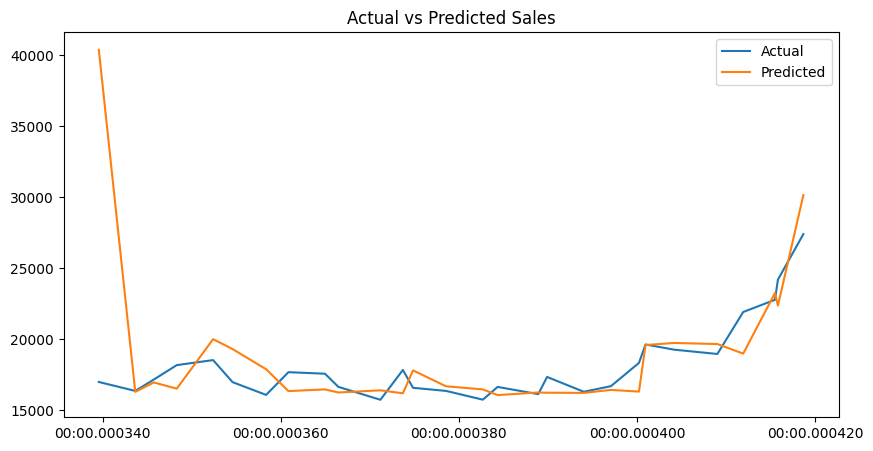

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

##Step 7: Rolling Averages and Seasonal Decomposition (Bonus)
I computed rolling averages and performed seasonal decomposition to analyze trends.

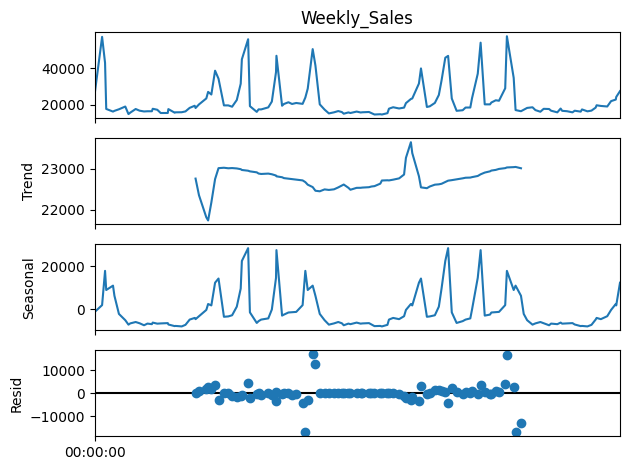

In [ ]:
df['Rolling_Mean'] = df['Weekly_Sales'].rolling(window=4).mean()  # 4-week rolling
decomp = seasonal_decompose(df['Weekly_Sales'], model='additive', period=52)  # Yearly seasonal
decomp.plot()
plt.show()

##Step 8: XGBoost with Time-Aware Validation (Bonus)
I used XGBoost with TimeSeriesSplit for time-aware validation.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
scores = []
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb_model.fit(X_tr, y_tr)
    y_val_pred = xgb_model.predict(X_val)
    scores.append(mean_absolute_error(y_val, y_val_pred))
print(f"Average CV MAE: {np.mean(scores):.2f}")

y_pred_xgb = xgb_model.predict(X_test)

Average CV MAE: 4136.06


##Step 9: Plot for XGBoost
I plotted actual vs. predicted sales for the XGBoost model.

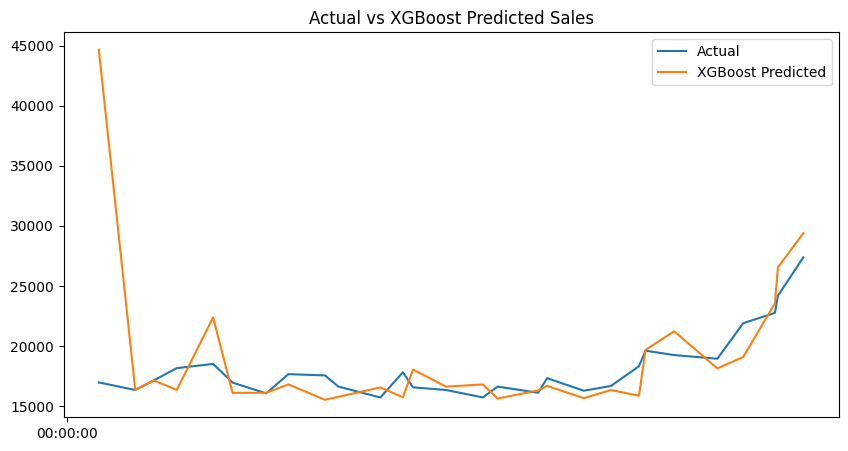

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Predicted')
plt.title('Actual vs XGBoost Predicted Sales')
plt.legend()
plt.show()